# PyHRF project

****

## 1. Loading packages and data


In [3]:
## Loading packages

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [4]:
## Loading nifti images

bold_dir = 'C:\\Users\\10755\\Desktop\\GLM\\inputs\\bolds'
mask_dir = 'C:\\Users\\10755\\Desktop\\GLM\\masks'
subject = 'S01'
bold = nib.load(os.path.join(bold_dir,'bold.nii'))
visual = nib.load(os.path.join(mask_dir,'mask_visual.nii'))
motor = nib.load(os.path.join(mask_dir,'mask_motor.nii'))
#motor = nib.load(os.path.join(file_dir,subject,'jde_vem_beta_map.nii'))

## Retrieving array for nifti images

data_bold = bold.get_fdata()
data_visual= np.squeeze(visual.get_fdata(),axis=3) # Delete last dimension corresponding to time (equal to 1 so useless)
data_motor = np.squeeze(motor.get_fdata(),axis=3) # Same


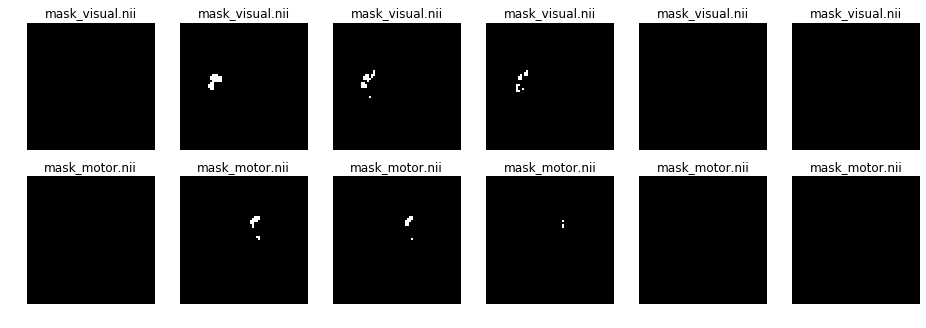

In [5]:
# Finding activation map according to the GLM


M = 6
fig=plt.figure(figsize=(16, 8))
for i in range(M):

    plt.subplot(3,M,M+i+1)
    plt.imshow(data_visual[:,:,i],cmap='gray') # Showing mask_visual.nii
    plt.title("mask_visual.nii")
    plt.axis('off')
    plt.subplot(3,M,2*M+i+1)
    plt.imshow(data_motor[:,:,i],cmap='gray') # Showing mask_motor.nii
    plt.title("mask_motor.nii")
    plt.axis('off')

## 2. Understanding data

In [6]:
bold?

In [7]:
print("bold.affine")
print(bold.affine)
print("bold.header")
print(bold.header)

bold.affine
[[  -4.            0.            0.          128.        ]
 [   0.            2.39050055   -5.89305019 -122.17176819]
 [   0.            3.20710278    4.39254475  -93.94556427]
 [   0.            0.            0.            1.        ]]
bold.header
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  64  64   6 654   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         4.         4.         7.3499994  0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glma

## 3. Data visualisation

data_bold.shape
(64, 64, 6, 654)


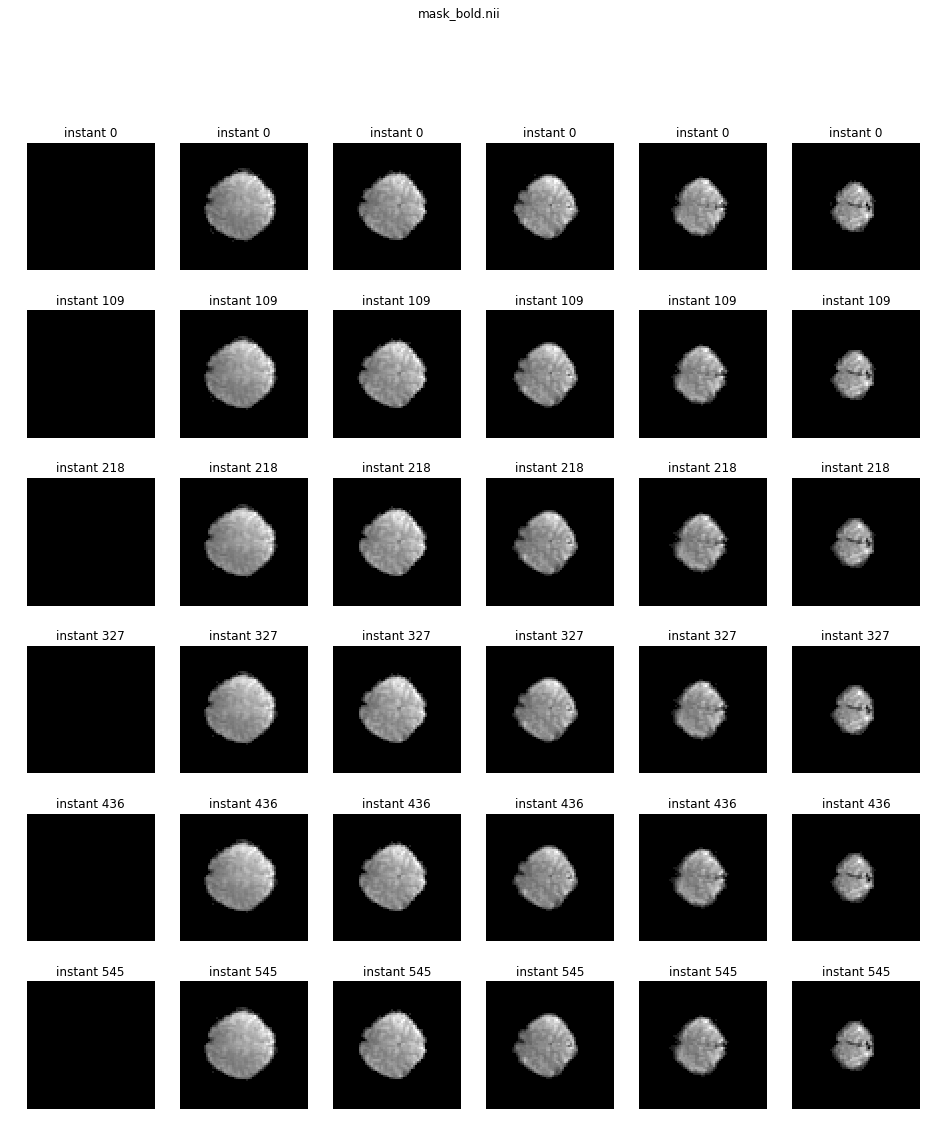

In [8]:
%matplotlib inline

## Showing bold data for each sections for different times
print("data_bold.shape")
print(data_bold.shape)
N = data_bold.shape[3]
M = data_bold.shape[2]
nb_im = 6
fig=plt.figure(figsize=(16, 18))
for j in range(nb_im): # Show nb_im images for each section
    for i in range(M):
        plt.subplot(nb_im,M,i+1+j*M)
        instant = j*int(N/nb_im)
        plt.imshow(data_bold[:,:,i,instant],cmap='gray')
        plt.axis('off')
        plt.title("instant " + str(instant))
plt.suptitle("mask_bold.nii")
plt.show()

In [9]:
'''## Loading packages

from nipy.testing import anatfile
from nipy import load_image
import os
import os.path as path
import nibabel as nib
import nilearn.plotting as niplot
from nipy import save_image

## Selecting data to see
os.chdir(os.path.join(file_dir,subject))
bold3D = load_image('bold.nii')[:,:,:,200] #Arbitrary time
os.chdir(file_dir)

save_name = 'bold3D_200.nii'
save_image(bold3D, os.path.normpath(os.path.join(file_dir, subject, save_name)))
bold3D_path = os.path.normpath(os.path.join(file_dir, subject, save_name))

## Viewing with nilearn
view = niplot.view_img(bold3D_path, threshold=3)
#view.open_in_browser()
view
'''

"## Loading packages\n\nfrom nipy.testing import anatfile\nfrom nipy import load_image\nimport os\nimport os.path as path\nimport nibabel as nib\nimport nilearn.plotting as niplot\nfrom nipy import save_image\n\n## Selecting data to see\nos.chdir(os.path.join(file_dir,subject))\nbold3D = load_image('bold.nii')[:,:,:,200] #Arbitrary time\nos.chdir(file_dir)\n\nsave_name = 'bold3D_200.nii'\nsave_image(bold3D, os.path.normpath(os.path.join(file_dir, subject, save_name)))\nbold3D_path = os.path.normpath(os.path.join(file_dir, subject, save_name))\n\n## Viewing with nilearn\nview = niplot.view_img(bold3D_path, threshold=3)\n#view.open_in_browser()\nview\n"

## 4. Applying General linear model (GLM)

In [10]:
# Loading useful functions from nipy

from nipy.modalities.fmri.glm import GeneralLinearModel  # Model to fit on data
from nipy.modalities.fmri.design_matrix import make_dmtx # Function to create the design matrix
from nipy.modalities.fmri.experimental_paradigm import BlockParadigm # Parameter object for make_dmtx 


C:\Users\10755\Anaconda3\lib\site-packages\nipy\modalities\fmri\glm.py:127: RuntimeWarning: invalid value encountered in true_divide
  (ols_result.resid ** 2).sum(0))
C:\Users\10755\Anaconda3\lib\site-packages\nipy\algorithms\utils\matrices.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X<=0, 0, 1. / X)


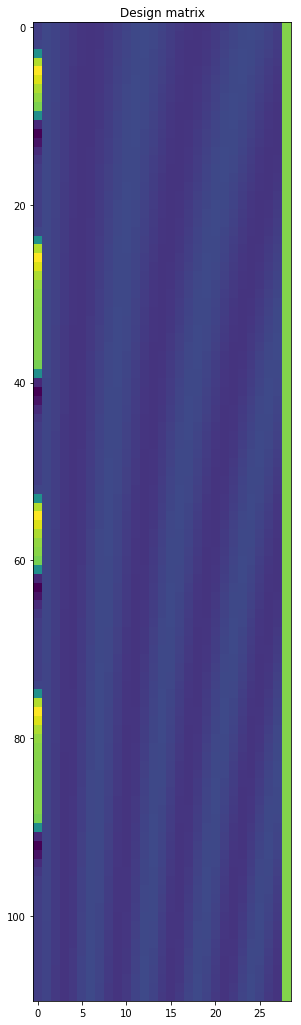

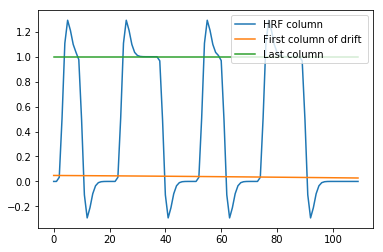

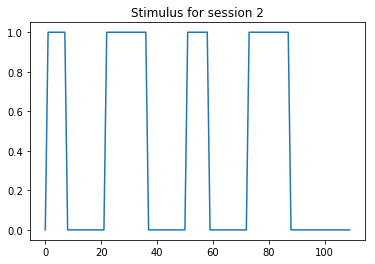

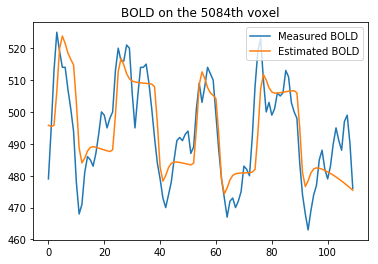

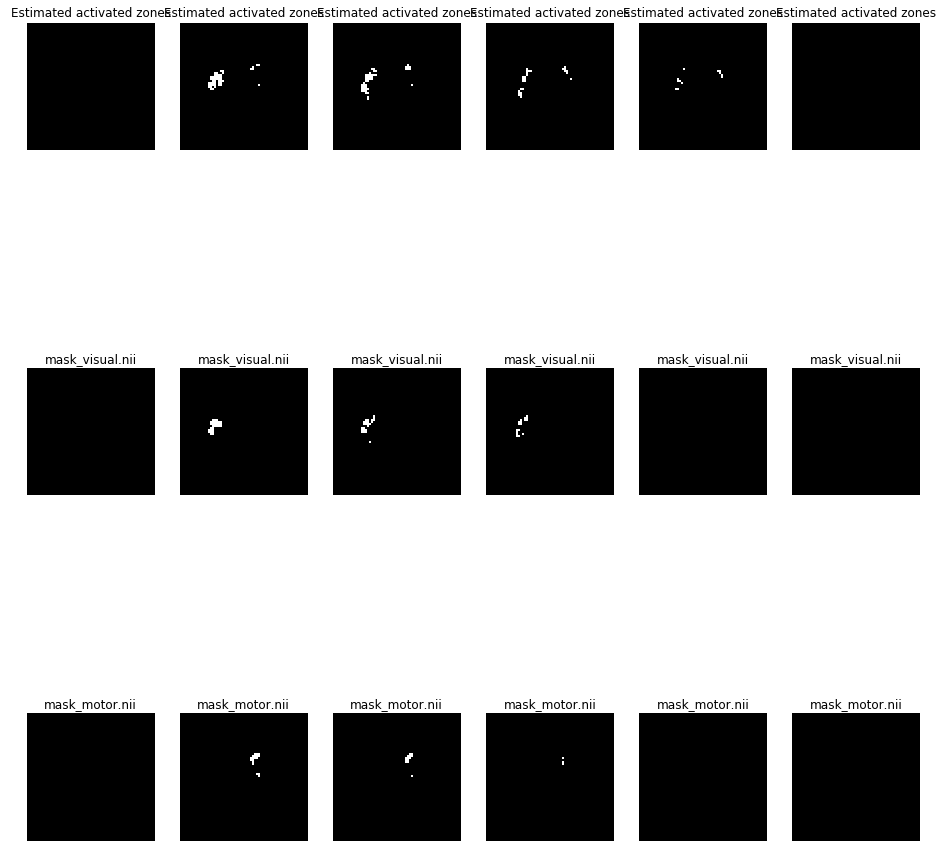

In [22]:
# Working session

session_ind = np.arange(0,654) # Whole csv file

## Loading and converting csv file
paradigms_dir = 'C:\\Users\\10755\\Desktop\\GLM/inputs/paradigmes'
data_csv = np.genfromtxt(os.path.join(paradigms_dir,'signal_stim.csv'),delimiter=',')      # First column is session, second is type of experiment, third is time, 
                                                               # Fourth is each stimulus duration, fifth is amplitude of stimulus (0 or 1)
data_csv = np.array(data_csv,dtype='float') # Convert into array
time = data_csv[session_ind,2]
data_bold_glm = np.zeros((64,64,6,len(time))) # Data considered in the GLM
data_bold_glm[:,:,:,:len(time)] = data_bold[:,:,:,:len(time)] # Data to be fitted
array_bold_glm = np.reshape(data_bold_glm.T,(data_bold_glm.shape[-1],64*64*6)) # We reshape to have a 2D array (times,voxels)

# paradigm = data_csv[session_ind,1]
## Retrieving csv data
conditions = data_csv[session_ind,1]
durations = data_csv[session_ind,3]
amplitudes = data_csv[session_ind,4]

## Applying GLM
# time = np.array([2.76, 82.80, 140.76, 220.80])
# durations = np.array([40, 20, 40, 20])
# conditions = np.array(['exp','exp','exp','exp'])
paradigm = BlockParadigm(con_id=conditions, onset=time, duration=durations, amplitude=amplitudes)
design_matrix = make_dmtx(time, paradigm, hrf_model='canonical',drift_model='cosine').matrix # Shape : nb_time*nb_regressors
glm = GeneralLinearModel(design_matrix) # X
glm.fit(array_bold_glm) # y

## Computing the best linear unbiased estimated of model parameters

blue = np.array(glm.get_beta())
blue_hrf = blue[0,:] # Get only parameters linked to the convolution part in the GLM, not the drift
blue_tensor = np.reshape(blue_hrf,(6,64,64)).T # Inverse reshape to get the blue for a 3D-voxel

## Plotting

# Working session

nb_session = 2
session_ind = np.arange((nb_session-1)*109,nb_session*109+1) # Retrieving only 2nd session

# Showing the design matrix

fig=plt.figure(figsize=(16, 18))
plt.imshow(design_matrix[session_ind,:])
plt.title("Design matrix")

plt.figure()
plt.plot(design_matrix[session_ind,0],label="HRF column ") # Column of the design matrix corresponding to the HRF
plt.plot(design_matrix[session_ind,1],label="First column of drift ") # Column of the design matrix corresponding to the first component of the drift
plt.plot(design_matrix[session_ind,-1],label="Last column") # Last column of the design matrix
plt.legend(loc='upper right')

# Stimulus

plt.figure()
plt.plot(amplitudes[session_ind])
plt.title('Stimulus for session ' + str(nb_session))

# BOLD on an activated voxel
data_visual_reshape = np.reshape(data_visual.T,(64*64*6)) # Reshape to use indices in array_bold_glm
i = np.nonzero(data_visual_reshape)[0][3] # Find an activated voxel according to the theoretical mask

plt.figure()
plt.plot(array_bold_glm[session_ind,i],label="Measured BOLD")
glm_voxel = np.dot(design_matrix,blue[:,i]) # Compute estimated BOLD by GLM
plt.plot(glm_voxel[session_ind],label="Estimated BOLD")
plt.title('BOLD on the ' + str(i) + 'th voxel')
plt.legend(loc='upper right')

# Finding activation map according to the GLM

z_contrast = glm.contrast(np.eye(design_matrix.shape[1])[0]).z_score() # Contrast on the HRF part
activation_map = np.reshape(np.array(z_contrast),(6,64,64)).T # Reshape to have a map for each section
threshold = 0.6 # Heuristically found
activation_map_thresholded = np.where(activation_map>threshold*np.max(activation_map),1,0) # Applying the threshold to get a binary map
M = activation_map.shape[2]
fig=plt.figure(figsize=(16, 18))
for i in range(M):
    plt.subplot(3,M,i+1)
    plt.imshow(activation_map_thresholded[:,:,i],cmap='gray')
    plt.title("Estimated activated zones")
    plt.axis('off')
    plt.subplot(3,M,M+i+1)
    plt.imshow(data_visual[:,:,i],cmap='gray') # Showing mask_visual.nii
    plt.title("mask_visual.nii")
    plt.axis('off')
    plt.subplot(3,M,2*M+i+1)
    plt.imshow(data_motor[:,:,i],cmap='gray') # Showing mask_motor.nii
    plt.title("mask_motor.nii")
    plt.axis('off')
    
plt.show()

In [28]:
mem = np.memmap(os.path.join('C:\\Users\\10755\\Desktop\\GLM',"memmap_array"),dtype='float64', mode='w+', shape=activation_map_thresholded.shape)
mem[:] = activation_map_thresholded[:]

ppm = nib.Nifti1Image(mem, bold.affine)
nib.save(ppm, os.path.join('GLM\\Outputs','ppm.nii'))

OSError: [Errno 22] Invalid argument: 'C:\\Users\\10755\\Desktop\\GLM\\memmap_array'

## 5. Modifying initial CSV file

In [ ]:
import csv
import os
file_dir = os.getcwd()
subject = 'S01'

## Read initial CSV

with open(os.path.join(file_dir,subject,'signal_stim_sans_indice.csv'),'r') as File:
    reader = csv.reader(File, delimiter='\t', quotechar=',',
                        quoting=csv.QUOTE_MINIMAL)
    row = []
    for row_read in reader:
        row.append(row_read) # Store each row
        
row_clear = row[1:] # Clear header
row_csv = []
for i in range(len(row_clear)):
    #row_csv.append([int(i//109+1), "exp", float(row_clear[i][0]), 2.76, float(row_clear[i][1])]) # First column is session, second is type of experiment, third is time, 
    row_csv.append([1, "exp", float(row_clear[i][0]), 0., float(row_clear[i][1])]) # First column is session, second is type of experiment, third is time, 
                                                               # Fourth is each stimulus duration, fifth is amplitude of stimulus (0 or 1)

## Write new CSV file with all data
with open(os.path.join(file_dir,subject,'signal_stim_test.csv'), 'w') as File:
    writer = csv.writer(File)
    writer.writerows(row_csv)
     
print("Writing complete")